In [114]:
import numpy as np
import matplotlib.pyplot as plt

#MNIST dataset
import torch
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Deep inverse imports
import deepinv as dinv
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.models import DnCNN, DRUNet, GSDRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP, RED
from deepinv.utils.parameters import get_GSPnP_params
from deepinv.optim.optimizers import optim_builder


torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

In [22]:
transform = transforms.Compose([transforms.ToTensor()])
noise = 0.1
train_dataset = datasets.MNIST(root=".", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=".", train=False, transform=transform, download=True)

radon = dinv.physics.Tomography(
    angles=28,
    img_width=28,
    noise_model=dinv.physics.noise.GaussianNoise(sigma = noise),
    device=device,
)



In [3]:
"""
deepinv_datasets_path = dinv.datasets.generate_dataset(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    physics=physics,
    device=device,
    save_dir="MNIST",
    train_datapoints=100,
    test_datapoints=10,
)
train_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=True)
test_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=False)

"""
train_dataloader = DataLoader(train_dataset, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=False)

## Parameters and priors 
 - stepsize, lambda, noise level, iterations and priors defined

In [95]:
params = {"stepsize": 0.01, "lambda": 1, "g_param": noise}
max_iter = 150
channels = 1 #3 for RGB, 1 for greyscale
forward = L2()

# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)

# Classical priors
tvprior = dinv.optim.prior.TVPrior(n_it_max = max_iter)
bm3dprior = dinv.models.BM3D()



In [44]:
priorbm3d = PnP(denoiser = bm3dprior)
prior1 = PnP(denoiser = dncnn)
prior2 = PnP(denoiser = drunet)



## Gradient-Step PnP setup

In [115]:
class GSPnP(RED):
    r"""
    Gradient-Step Denoiser prior.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.explicit_prior = True

    def g(self, x, *args, **kwargs):
        r"""
        Computes the prior :math:`g(x)`.

        :param torch.tensor x: Variable :math:`x` at which the prior is computed.
        :return: (torch.tensor) prior :math:`g(x)`.
        """
        return self.denoiser.potential(x, *args, **kwargs)

In [128]:
gsdrunet =GSDRUNet(in_channels= 1,
    out_channels= 1,
    pretrained = "download",
    device = "cpu"
)

gsprior = GSPnP(denoiser = gsdrunet)

RuntimeError: Error(s) in loading state_dict for GSPnP:
	size mismatch for student_grad.model.m_head.weight: copying a param with shape torch.Size([64, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 2, 3, 3]).
	size mismatch for student_grad.model.m_tail.weight: copying a param with shape torch.Size([3, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 64, 3, 3]).

# PnP-PGD/FBS

In [124]:
model1 = optim_builder(
    iteration="PGD",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

#DnCNN
model2 = optim_builder(
    iteration="PGD",
    prior= prior1,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
model3 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

modelbm3d = optim_builder(
    iteration="PGD",
    prior= priorbm3d,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


modelGSPnP = optim_builder(
    iteration="PGD",
    prior= gsprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)



In [8]:
mnist = MNIST(root='./data', train=True, download=True, transform=transform)
digit, label = mnist[0]
#plt.imshow(digit.view(28, 28))

In [ ]:
y = radon(digit.reshape(1, 1, 28, 28))
fbp = radon.A_dagger(y)

In [97]:
x_model1, metrics1 = model1(y, radon, x_gt = digit, compute_metrics = True)
x_model2, metrics2 = model2(y, radon, x_gt = digit, compute_metrics = True)
x_model3, metrics3 = model3(y, radon, x_gt = digit, compute_metrics = True)
x_modelbm3d, metricsbm3d = modelbm3d(y, radon, x_gt = digit, compute_metrics = True)

In [126]:
#GS-PnP
x_modelgs, metricsgs = modelGSPnP(y, radon, x_gt = digit, compute_metrics = True)

c:\Users\as5057\python-test\venv\Lib\site-packages\deepinv\optim\fixed_point.py:7: SyntaxWarning: invalid escape sequence '\q'
  """


RuntimeError: Given groups=1, weight of size [64, 4, 3, 3], expected input[1, 2, 32, 32] to have 4 channels, but got 2 channels instead

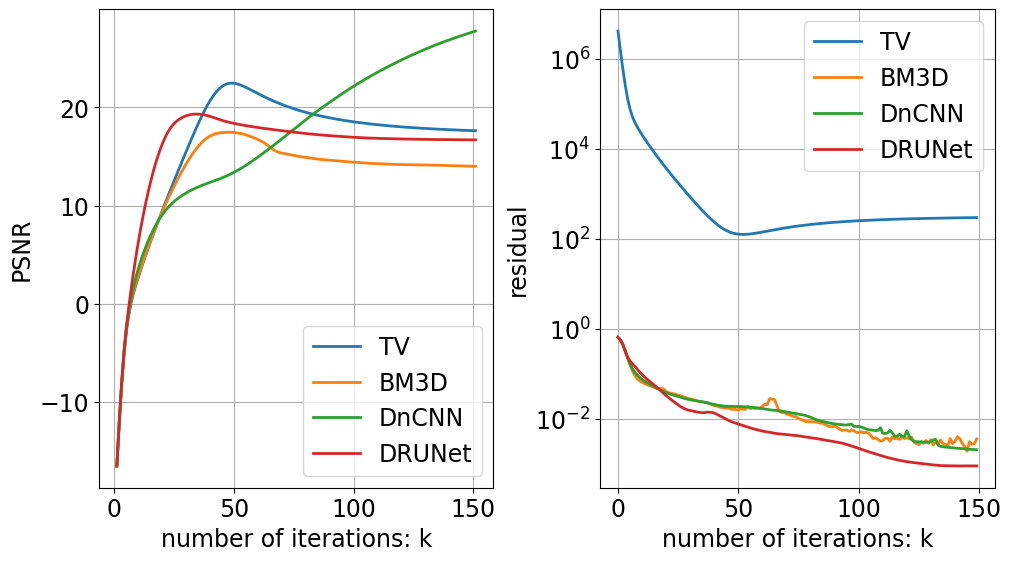

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
def plot_psnrs_residuals(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """


    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()
    #fig.suptitle(method)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(residuals, label = method)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)

plot_psnrs_residuals(metrics1, 'TV')
plot_psnrs_residuals(metricsbm3d, 'BM3D')
plot_psnrs_residuals(metrics2, 'DnCNN')
plot_psnrs_residuals(metrics3, 'DRUNet')

ax1.legend()
ax2.legend()

## Plotting functions for the different estimates

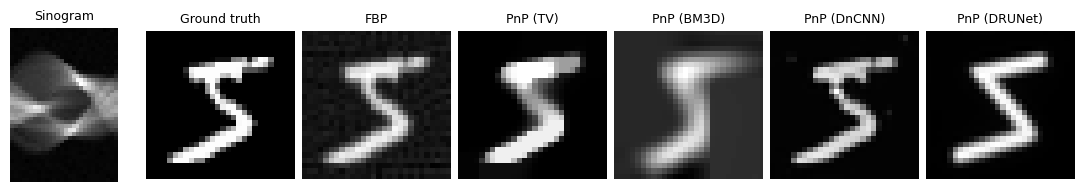

In [99]:
imgs = [y, digit, fbp, x_model1, x_modelbm3d, x_model2, x_model3]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "PnP (TV)", "PnP (BM3D)", "PnP (DnCNN)", "PnP (DRUNet)"])

In [100]:
def plt_ready(ground_truth, y, FBP, x_tv, x_bm3d, x_dncnn, x_drunet, imsize):
    sinogram = y.view(40,28)
    gt = ground_truth.view(imsize)
    fbp = FBP.view(imsize)
    tv_x = x_tv.view(imsize)
    bm3d_x = x_bm3d.view(imsize)
    dncnn_x = x_dncnn.view(imsize)
    drunet_x = x_drunet.view(imsize)

    return sinogram, gt, fbp, tv_x, bm3d_x, dncnn_x, drunet_x

def plotting_estimates(gt, fbp, x1, x2, x3, x4):
    fig, axs = plt.subplots(2, 3, figsize=(10, 6.5))
    axs[0, 0].set_title("Ground Truth")
    axs[0, 0].imshow(gt, cmap='gray')
    axs[0, 1].set_title("FBP")
    axs[0, 1].imshow(fbp, cmap='gray')
    axs[0, 2].set_title("TV")
    axs[0, 2].imshow(x1, cmap='gray')
    axs[1, 0].set_title("BM3D")
    axs[1, 0].imshow(x2, cmap='gray')
    axs[1, 1].set_title("PnP (DnCNN)")
    axs[1, 1].imshow(x3, cmap='gray')
    axs[1, 2].set_title("PnP (DRUNet)")
    axs[1, 2].imshow(x4, cmap='gray')

    for i in range(2):
        for j in range(3):
            axs[i, j].axis('off')


imsize = (28, 28)

<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
C:\Users\as5057\AppData\Local\Temp\ipykernel_20116\1289958391.py:5: SyntaxWarning: invalid escape sequence '\T'
  plt.xlabel("Projection angle ($\Theta$)")


Text(0.5, 0, 'Projection angle ($\\Theta$)')

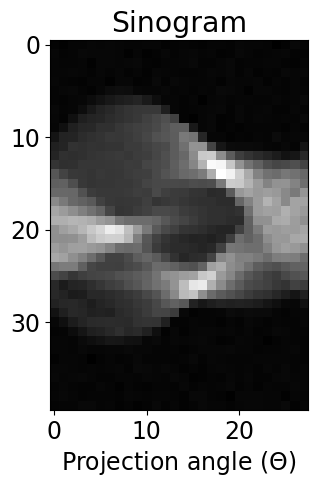

In [101]:
sinogram, ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet = plt_ready(digit, y, fbp, x_model1, x_modelbm3d, x_model2, x_model3, imsize)

plt.imshow(sinogram, cmap = 'gray')
plt.title("Sinogram")
plt.xlabel("Projection angle ($\Theta$)")



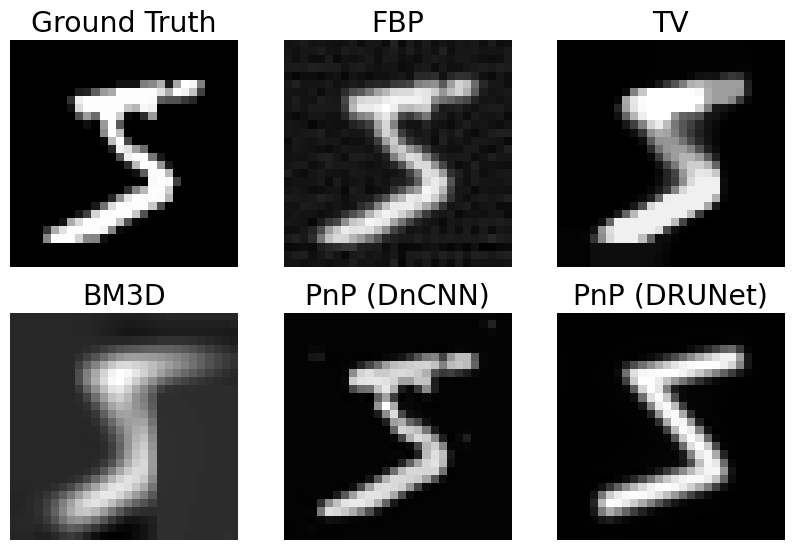

In [102]:
plotting_estimates(ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet)


# PnP-ADMM setup with the same priors

In [105]:
params = {"stepsize": 0.01, "lambda": 1, "beta": 1, "g_param": noise}
ADMM1 = optim_builder(
    iteration="ADMM",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

#DnCNN
ADMM2 = optim_builder(
    iteration="ADMM",
    prior= prior1,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
ADMM3 = optim_builder(
    iteration="ADMM",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

ADMMbm3d = optim_builder(
    iteration="ADMM",
    prior= priorbm3d,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


In [107]:
admm_model1, metrics_admm_1 = ADMM1(y, radon, x_gt = digit, compute_metrics = True)
admm_model2, metrics_admm_2 = ADMM2(y, radon, x_gt = digit, compute_metrics = True)
admm_model3, metrics_admm_3 = ADMM3(y, radon, x_gt = digit, compute_metrics = True)
admm_modelbm3d, metrics_admm_bm3d = ADMMbm3d(y, radon, x_gt = digit, compute_metrics = True)

In [ ]:
imgs = [y, digit, fbp, admm_model1, admm_modelbm3d, admm_model2, admm_model3]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "PnP (TV)", "PnP (BM3D)", "PnP (DnCNN)", "PnP (DRUNet)"])

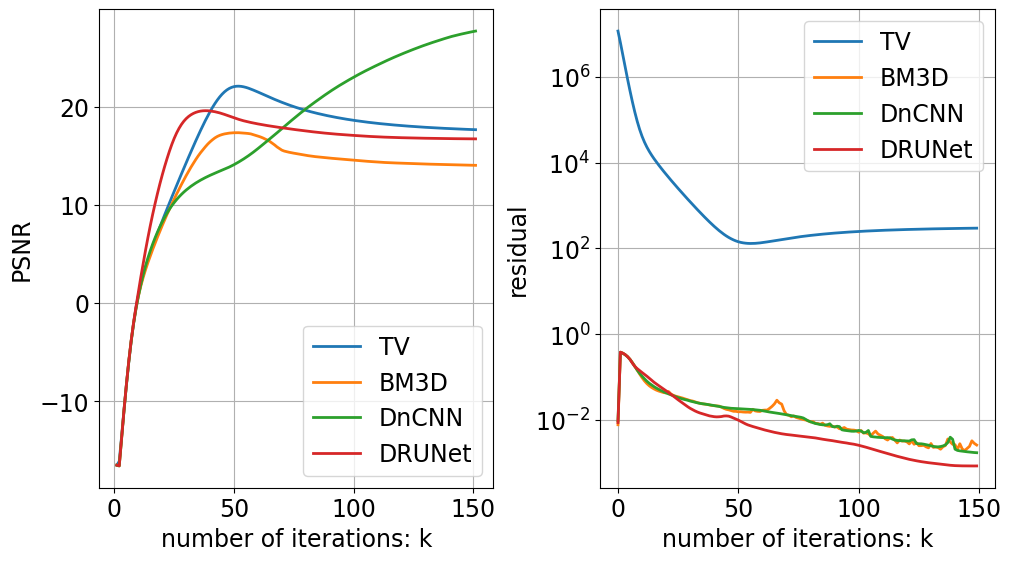

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
plot_psnrs_residuals(metrics_admm_1, 'TV')
plot_psnrs_residuals(metrics_admm_bm3d, 'BM3D')
plot_psnrs_residuals(metrics_admm_2, 'DnCNN')
plot_psnrs_residuals(metrics_admm_3, 'DRUNet')

ax1.legend()
ax2.legend()

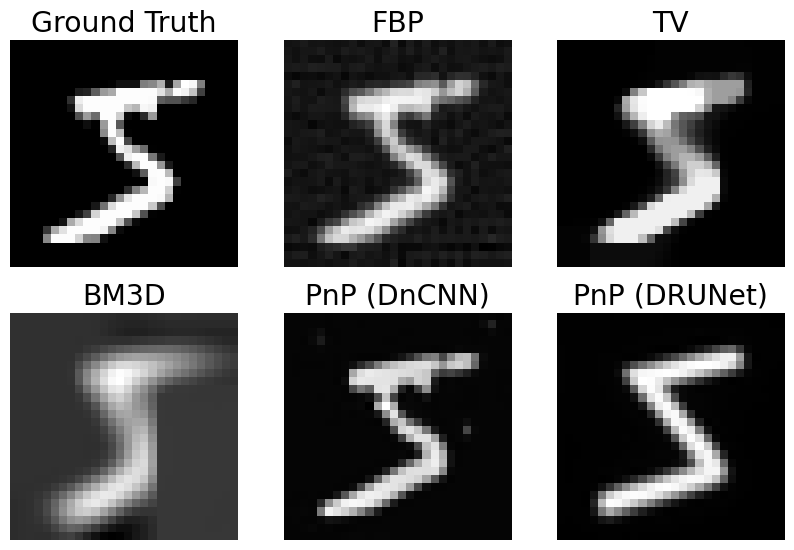

In [110]:
sinogram, ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet = plt_ready(digit, y, fbp, admm_model1, admm_modelbm3d, admm_model2, admm_model3, imsize)
plotting_estimates(ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet)